# 1. 라이브러리 로드

In [108]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.signal import correlate
from statsmodels.tsa.stattools import grangercausalitytests

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
sns.set_style("darkgrid")
rc('font', family='NanumGothic')  # 예: 나눔고딕 사용
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [2]:
estate_volume_df = pd.read_csv('final_dataset/refined_news_topic_sentiment.csv', index_col=0)
estate_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17075 entries, 0 to 17074
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   title                             17075 non-null  object 
 1   link                              17075 non-null  object 
 2   article                           17075 non-null  object 
 3   date                              17075 non-null  object 
 4   media                             17075 non-null  object 
 5   region_code                       17075 non-null  int64  
 6   region                            17075 non-null  object 
 7   district                          17075 non-null  object 
 8   yyyymm                            17075 non-null  object 
 9   text_length                       17075 non-null  int64  
 10  text_token_length                 17075 non-null  int64  
 11  article_summary                   17075 non-null  object 
 12  preproces

In [28]:
estate_volume_df.query("topic == 18")['title'].to_list()

['광진구, 아차산 둘레길 휴대전화 급속충전기 설치',
 '(구청브리프)서울 광진구, 아차산 둘레길 휴대전화 급속충전기 설치',
 '[수도권]구로구, 마을버스에도 와이파이',
 '구로구 “마을버스서 와이파이 공짜”',
 '구로구, 관내 모든 마을버스에 와이파이망 구축',
 '구로구, 전국 최초 마을버스에 와이파이존 구축',
 '구로구, 모든 마을버스에 와이파이 구축...전국 최초',
 '구로구, 전국 최초 마을버스에 무료 ‘와이파이존’ 구축',
 '동대문구, 주민 위해 스마트폰 충전기까지 설치',
 '[수도권]서울 상암동 ‘똑똑한 거리’ 확대',
 '양천구, 빵빵 터지는 무선인터넷(WiFi)존 설치']

In [3]:
# estate_volume_df = estate_volume_df.dropna()
# estate_volume_df.info()

# 3. 데이터 EDA

## 3.1 토픽 모델링 결과 EDA

In [36]:
# 토픽 모델 결과 정제
estate_topic_df = estate_volume_df[['yyyymm', 'district', 'title', 'topic', 'Name', 'Representation']]
estate_topic_df

,yyyymm,district,title,topic,Name,Representation
0,2024-09-01,동남권,서울 '알짜배기' 땅 매물로 나왔다…86억 강남 파출소 부지,0,0_개발_구역_계획_정비,"['개발', '구역', '계획', '정비', '사업', '지구', '부지', '도시..."
1,2024-09-01,동남권,[단독]서울시 10년 간 싱크홀 223건…강남구 28건 가장 많아,2,2_주차장_설치_안전_공사,"['주차장', '설치', '안전', '공사', '주민', '대상', '건물', '실..."
2,2024-09-01,동남권,양재역 인근에 18층 오피스…역세권 활성화 선정,-1,-1_사업_계획_구역_가구,"['사업', '계획', '구역', '가구', '정비', '주민', '개발', '도시..."
3,2024-09-01,동남권,압구정5구역 ‘70층 재건축’ 공식화,-1,-1_사업_계획_구역_가구,"['사업', '계획', '구역', '가구', '정비', '주민', '개발', '도시..."
4,2024-09-01,동남권,"강남 구룡마을, 13년 만 보상 돌입했지만…'비닐하우스'가 발목",-1,-1_사업_계획_구역_가구,"['사업', '계획', '구역', '가구', '정비', '주민', '개발', '도시..."
...,...,...,...,...,...,...
17070,2010-07-01,동북권,중랑구 ‘서촌노인문화센터’ 개관,-1,-1_사업_계획_구역_가구,"['사업', '계획', '구역', '가구', '정비', '주민', '개발', '도시..."
17071,2010-06-01,동북권,문병권 중랑구청장의 '교육특구' 열정 넘쳐,1,1_지원_사업_교육_주민,"['지원', '사업', '교육', '주민', '참여', '대상', '공동', '운영..."
17072,2010-06-01,동북권,"중랑구, 주택재건축 갈등 해소 앞장",1,1_지원_사업_교육_주민,"['지원', '사업', '교육', '주민', '참여', '대상', '공동', '운영..."
17073,2010-06-01,동북권,"[Seoul 요모조모-만원의 행복] 중랑 ‘사색의 길’, ‘장미터널’",-1,-1_사업_계획_구역_가구,"['사업', '계획', '구역', '가구', '정비', '주민', '개발', '도시..."


In [37]:
estate_topic_df['Name'].value_counts().to_frame()

,count
Name,
-1_사업_계획_구역_가구,7083
0_개발_구역_계획_정비,3547
1_지원_사업_교육_주민,2004
2_주차장_설치_안전_공사,1201
3_도서관_어린이_공원_조성,1020
4_토지_서비스_도로_정보,549
5_가격_분양_거래_전용,508
6_시설_지상_센터_규모,353
7_설치_가구_지원_사용,180


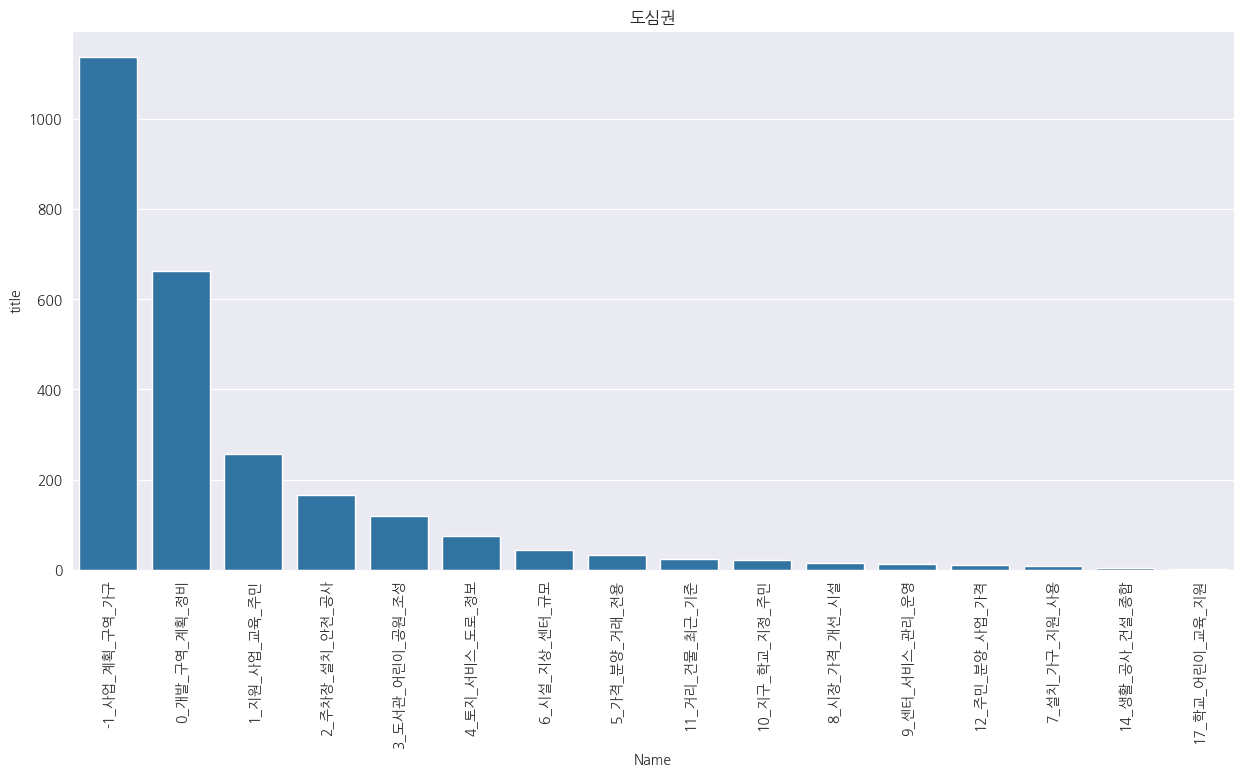

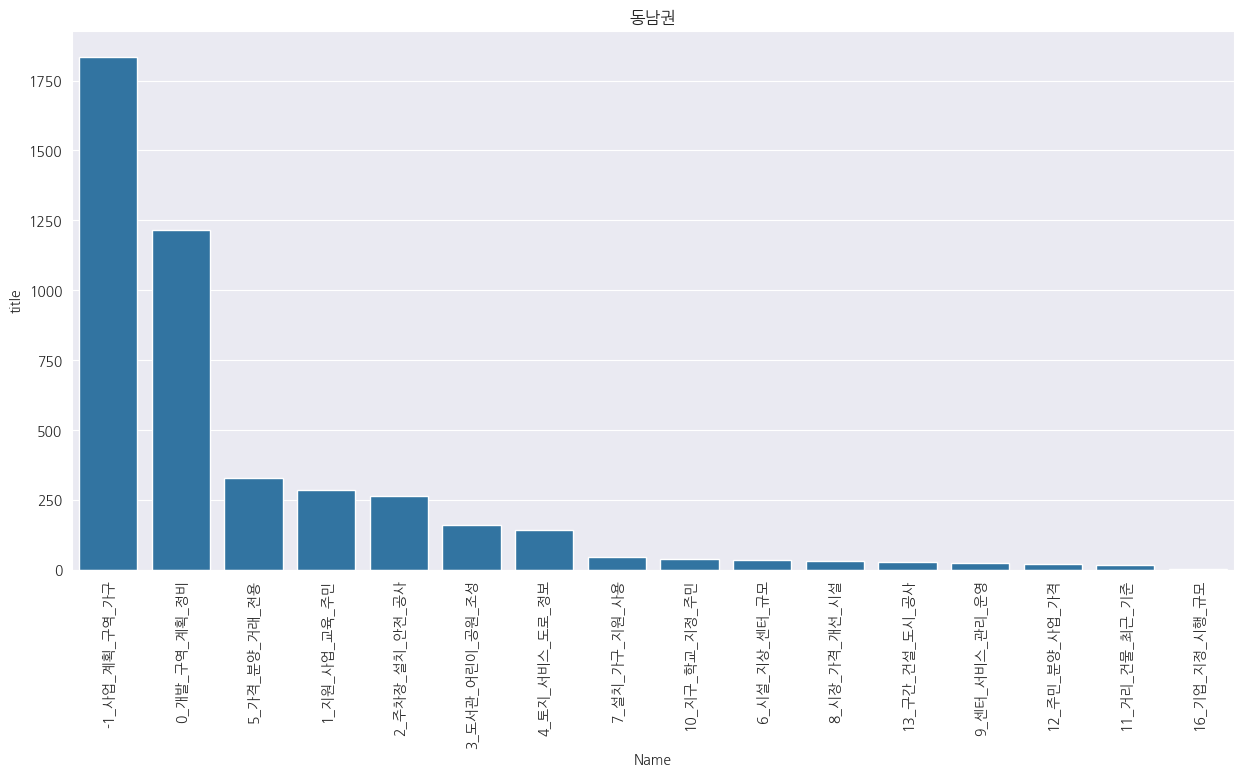

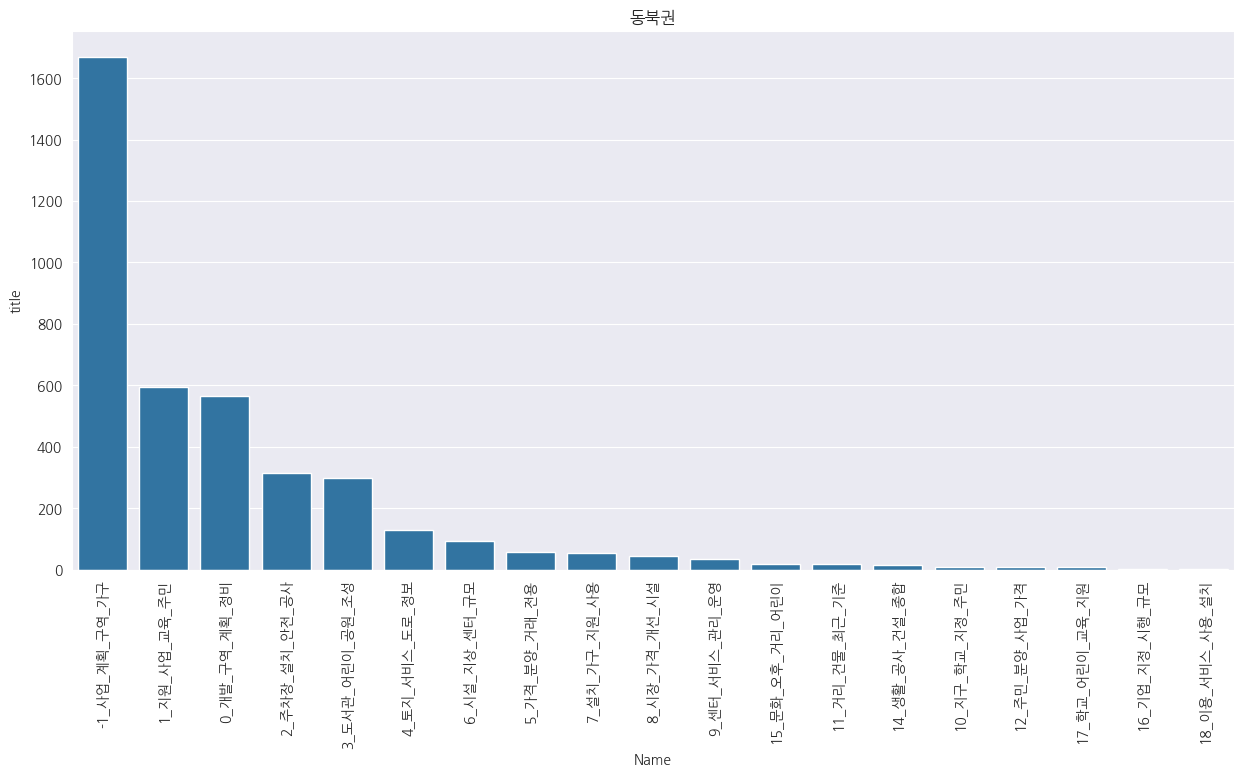

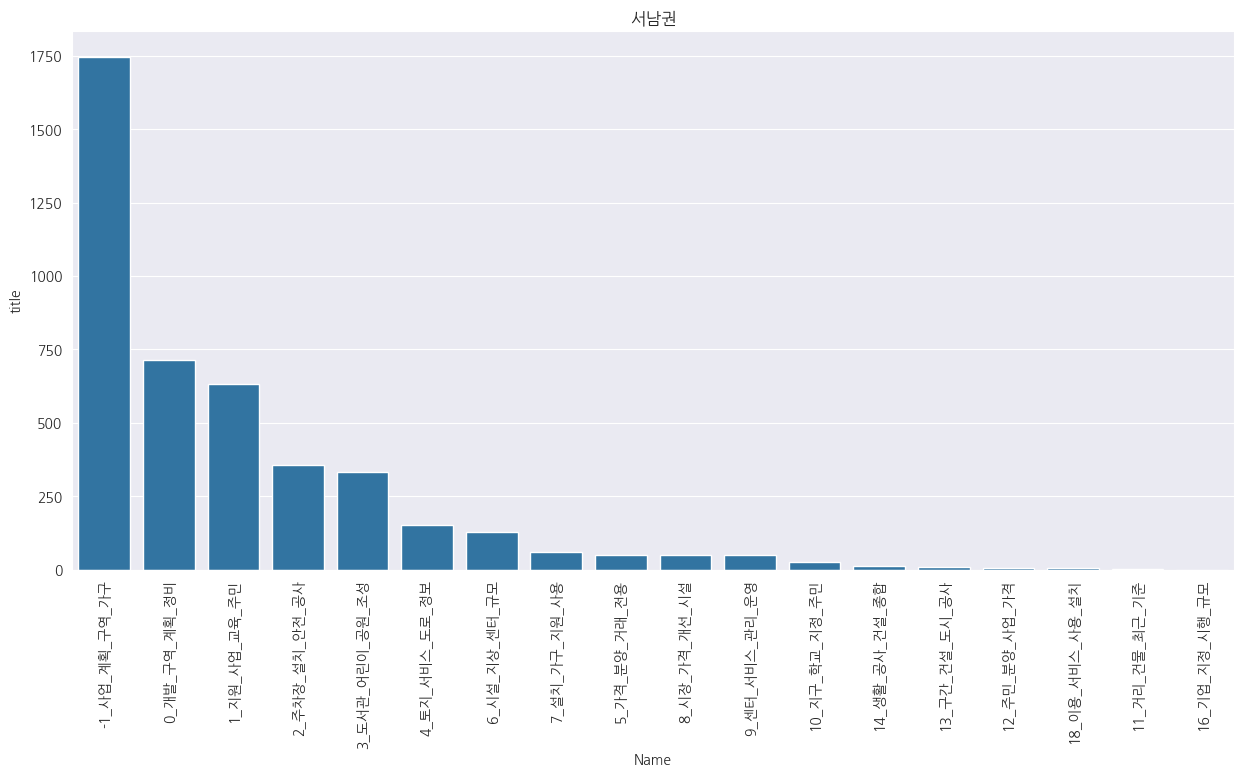

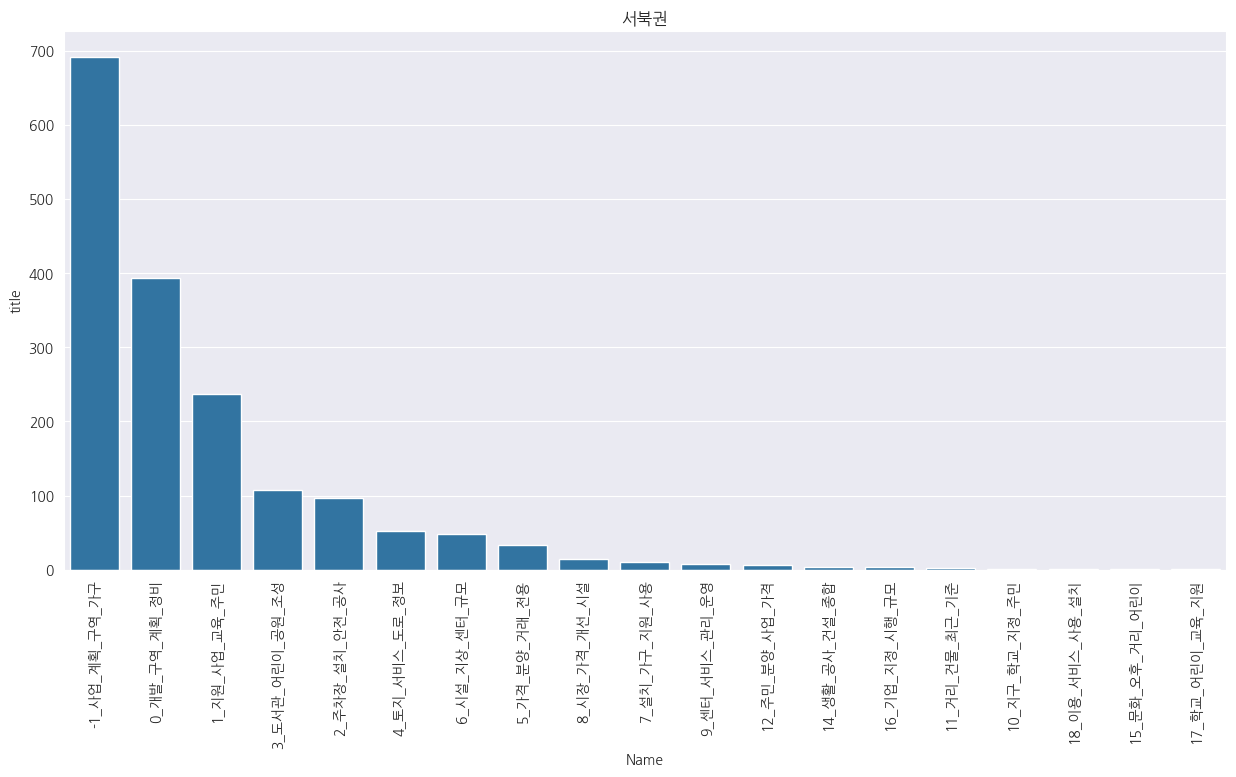

In [6]:
estate_topic_district_df = estate_topic_df.groupby(['district', 'Name']).count()['title'].reset_index()

for district in estate_topic_district_df['district'].unique():

    plt.figure(figsize=(15, 7))
    plt.title(district)
    sns.barplot(data=estate_topic_district_df.query(f"district == '{district}'").sort_values('title', ascending=False), x='Name', y='title')

    plt.xticks(rotation=90)
    plt.show()

In [38]:
# 데이터프레임 생성
data = {
    "Name": [
        "-1_사업_계획_구역_가구", "0_개발_구역_계획_정비", "11_거리_건물_최근_기준",
        "2_주차장_설치_안전_공사", "6_시설_지상_센터_규모", "7_설치_가구_지원_사용", "13_구간_건설_도시_공사",
        "1_지원_사업_교육_주민", "10_지구_학교_지정_주민", "17_학교_어린이_교육_지원",
        "5_가격_분양_거래_전용", "12_주민_분양_사업_가격",
        "3_도서관_어린이_공원_조성", "8_시장_가격_개선_시설", "15_문화_오후_거리_어린이",
        "4_토지_서비스_도로_정보", "9_센터_서비스_관리_운영", "18_이용_서비스_사용_설치",
        "14_생활_공사_건설_종합", "16_기업_지정_시행_규모"
    ],
    "topic_category": [
        "상권 개발 및 정비 사업", "상권 개발 및 정비 사업", "상권 개발 및 정비 사업",
        "시설 설치 및 안전 공사", "시설 설치 및 안전 공사", "시설 설치 및 안전 공사", "시설 설치 및 안전 공사",
        "주민 및 교육 지원 사업", "주민 및 교육 지원 사업", "주민 및 교육 지원 사업",
        "부동산 가격 및 분양 거래", "부동산 가격 및 분양 거래",
        "어린이 및 공원/문화 조성", "어린이 및 공원/문화 조성", "어린이 및 공원/문화 조성",
        "서비스 및 센터 운영", "서비스 및 센터 운영", "서비스 및 센터 운영",
        "부동산 정책 관련", "부동산 정책 관련"
    ]
}

topic_category_df = pd.DataFrame(data)

estate_topic_df = estate_topic_df.merge(topic_category_df, how='left', on='Name')
estate_topic_df['topic_category'].value_counts()

topic_category
상권 개발 및 정비 사업     10693
주민 및 교육 지원 사업      2111
시설 설치 및 안전 공사      1772
어린이 및 공원/문화 조성     1197
서비스 및 센터 운영         690
부동산 가격 및 분양 거래      562
부동산 정책 관련            50
Name: count, dtype: int64

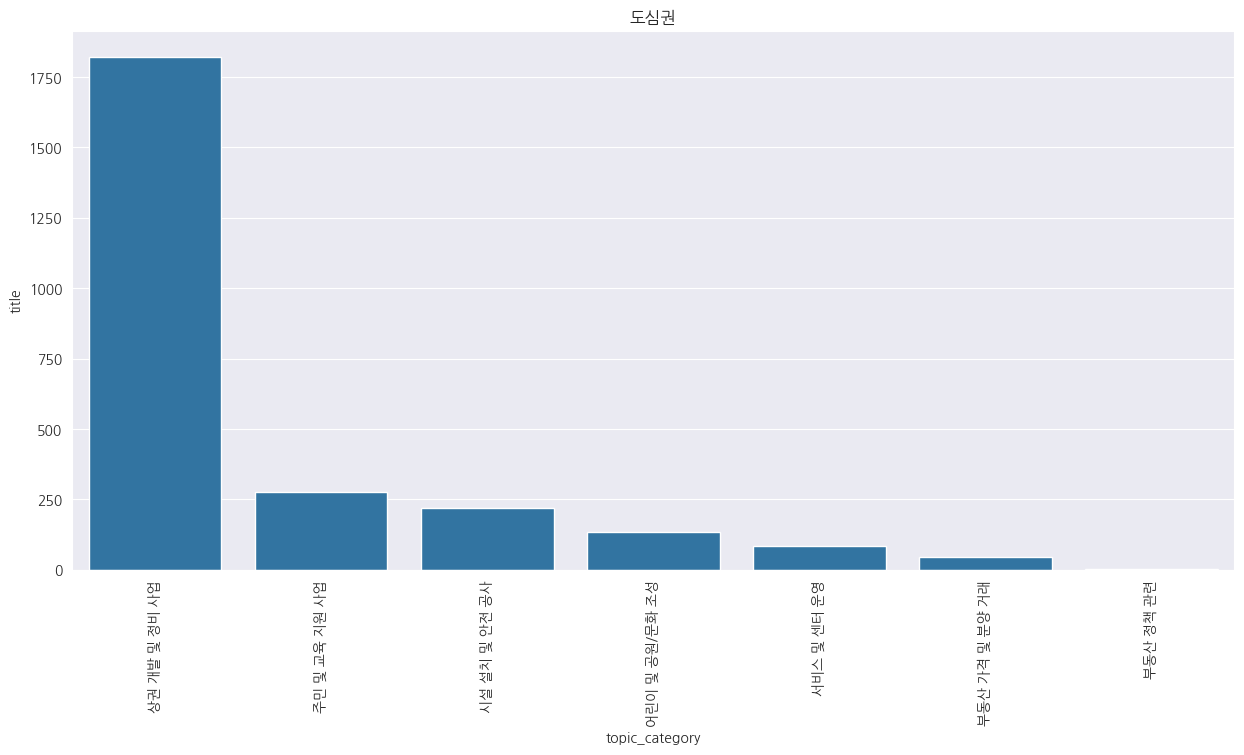

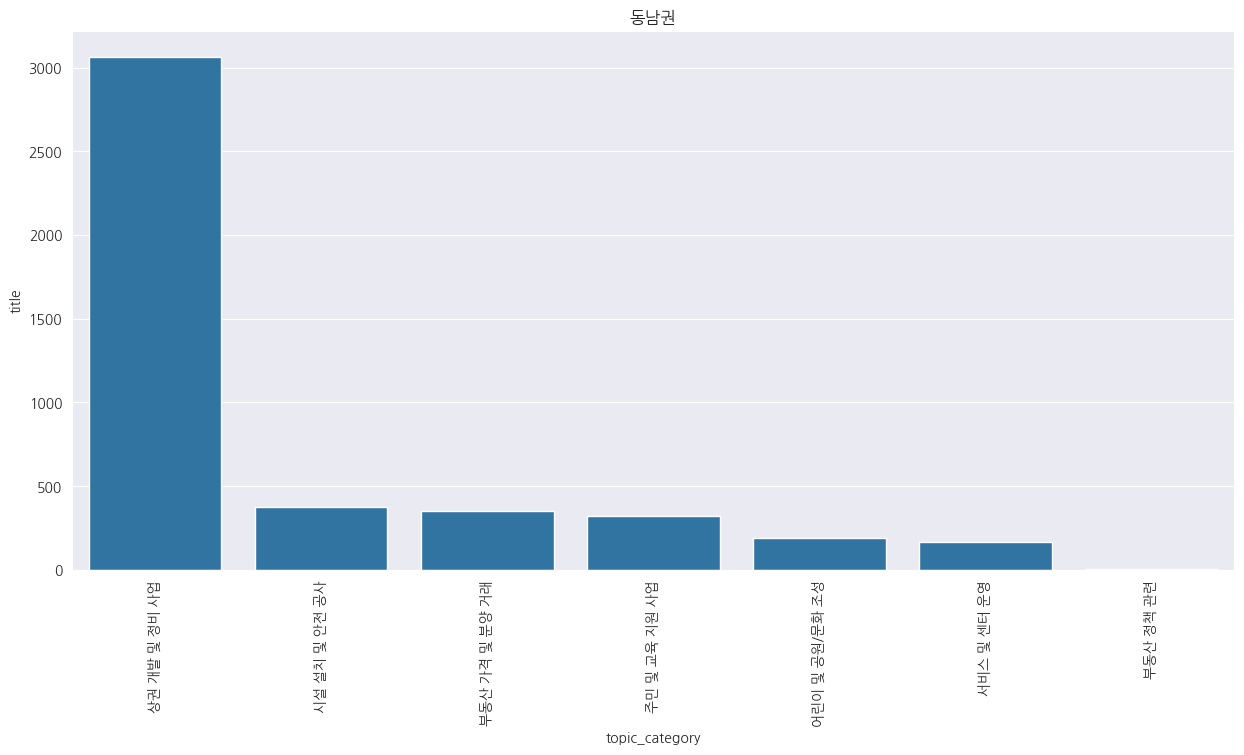

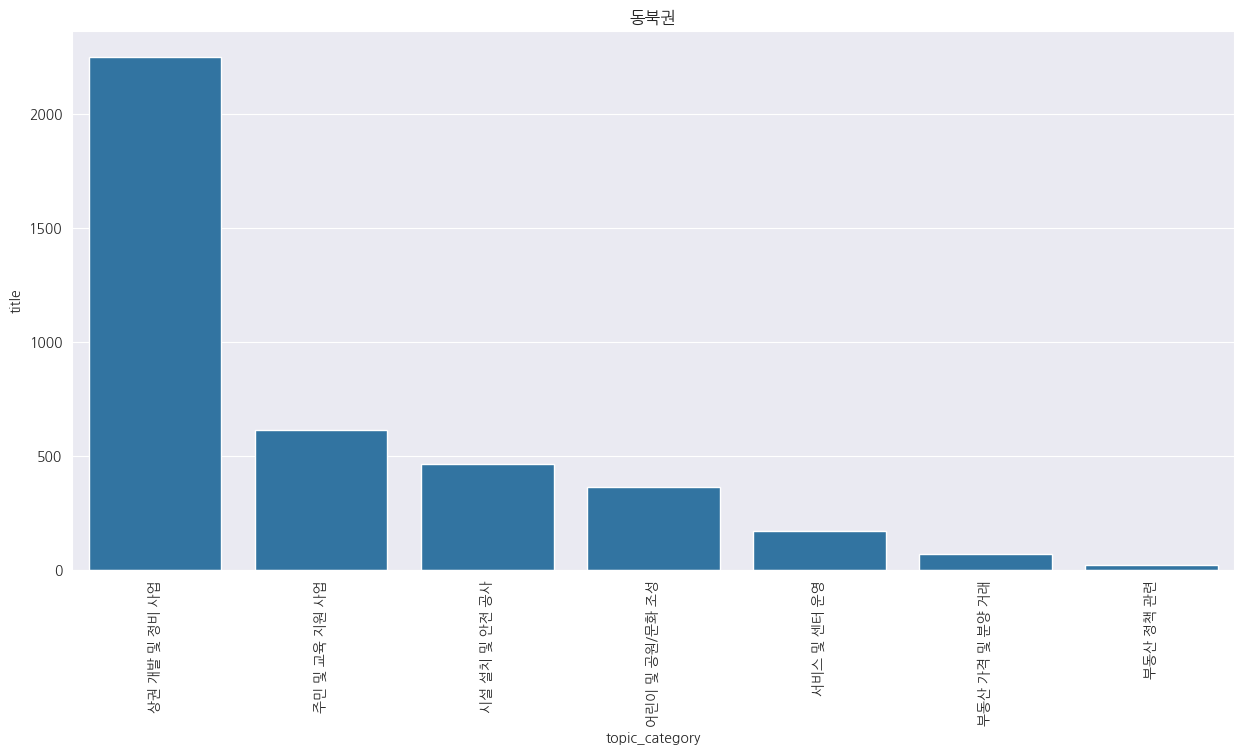

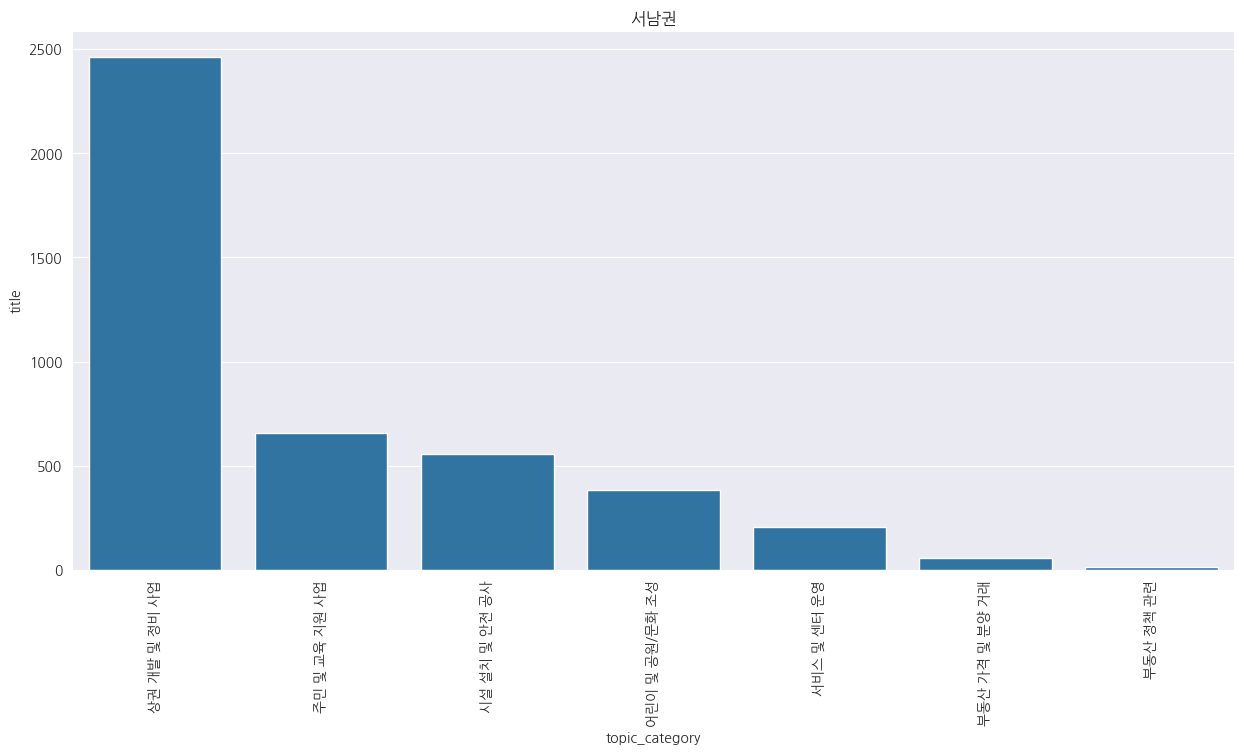

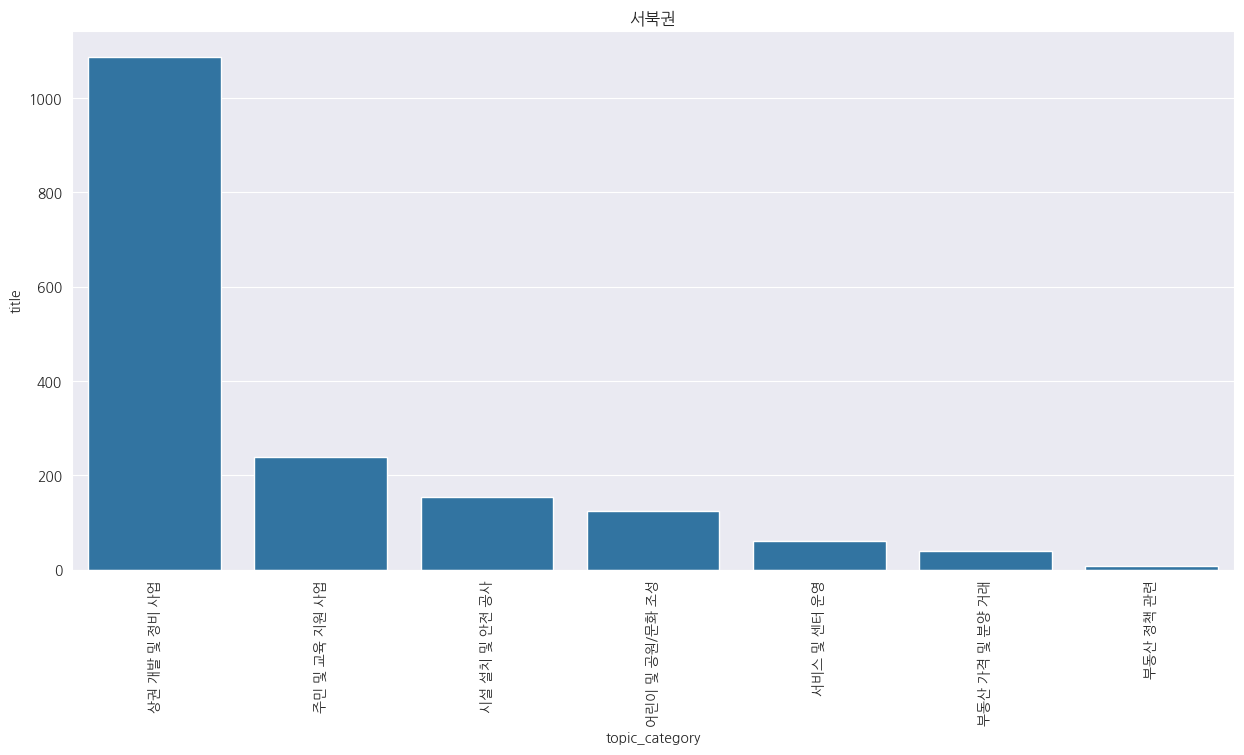

In [41]:
estate_topic_district_df = estate_topic_df.groupby(['district', 'topic_category']).count()['title'].reset_index()

for district in estate_topic_district_df['district'].unique():

    plt.figure(figsize=(15, 7))
    plt.title(district)
    sns.barplot(data=estate_topic_district_df.query(f"district == '{district}'").sort_values('title', ascending=False), x='topic_category', y='title')

    plt.xticks(rotation=90)
    plt.show()

## 3.2 감성 분석 결과 EDA

In [45]:
# 토픽 모델 결과 정제
estate_sentiment_df = estate_volume_df[['yyyymm', 'district', 'title', 'positive_ratio', 'neutral_ratio', 'negative_ratio']].dropna()
estate_sentiment_df

,yyyymm,district,title,positive_ratio,neutral_ratio,negative_ratio
0,2024-09-01,동남권,서울 '알짜배기' 땅 매물로 나왔다…86억 강남 파출소 부지,0.25,0.65,0.10
1,2024-09-01,동남권,[단독]서울시 10년 간 싱크홀 223건…강남구 28건 가장 많아,0.05,0.10,0.85
2,2024-09-01,동남권,양재역 인근에 18층 오피스…역세권 활성화 선정,0.45,0.40,0.15
3,2024-09-01,동남권,압구정5구역 ‘70층 재건축’ 공식화,0.00,1.00,0.00
4,2024-09-01,동남권,"강남 구룡마을, 13년 만 보상 돌입했지만…'비닐하우스'가 발목",0.10,0.10,0.80
...,...,...,...,...,...,...
17070,2010-07-01,동북권,중랑구 ‘서촌노인문화센터’ 개관,0.85,0.10,0.05
17071,2010-06-01,동북권,문병권 중랑구청장의 '교육특구' 열정 넘쳐,0.85,0.10,0.05
17072,2010-06-01,동북권,"중랑구, 주택재건축 갈등 해소 앞장",0.15,0.40,0.45
17073,2010-06-01,동북권,"[Seoul 요모조모-만원의 행복] 중랑 ‘사색의 길’, ‘장미터널’",0.65,0.25,0.10


# 4. 최종 결과 EDA

In [80]:
estate_volume_df2 = estate_volume_df.merge(topic_category_df, how='left', on='Name')

In [113]:
estate_sentiment_df_groupby_district = estate_volume_df2.groupby('district')[['positive_ratio', 'neutral_ratio', 'negative_ratio']].mean()
estate_sentiment_df_groupby_district['ratio_sum'] = estate_sentiment_df_groupby_district['positive_ratio'] + estate_sentiment_df_groupby_district['neutral_ratio'] + estate_sentiment_df_groupby_district['negative_ratio']

estate_sentiment_df_groupby_district

,positive_ratio,neutral_ratio,negative_ratio,ratio_sum
district,,,,
도심권,0.452584,0.329768,0.217648,1.0
동남권,0.399165,0.320461,0.280374,1.0
동북권,0.533801,0.299931,0.166267,1.0
서남권,0.540573,0.299187,0.160240,1.0
서북권,0.510240,0.321855,0.167905,1.0


In [85]:
final_estate_news_df = estate_volume_df2[['district', 'title', 'yyyymm', 'topic_category', 'positive_ratio', 'neutral_ratio', 'negative_ratio']].dropna()
final_estate_news_df = final_estate_news_df.groupby(['district', 'yyyymm', 'topic_category'])[['positive_ratio', 'neutral_ratio', 'negative_ratio']].mean().reset_index()

final_estate_news_df['total_positive_ratio'] = estate_volume_df2.groupby(['district', 'yyyymm'])['positive_ratio'].transform('mean')
final_estate_news_df['total_neutral_ratio'] = estate_volume_df2.groupby(['district', 'yyyymm'])['neutral_ratio'].transform('mean')
final_estate_news_df['total_negative_ratio'] = estate_volume_df2.groupby(['district', 'yyyymm'])['negative_ratio'].transform('mean')

final_estate_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district              2577 non-null   object 
 1   yyyymm                2577 non-null   object 
 2   topic_category        2577 non-null   object 
 3   positive_ratio        2577 non-null   float64
 4   neutral_ratio         2577 non-null   float64
 5   negative_ratio        2577 non-null   float64
 6   total_positive_ratio  2577 non-null   float64
 7   total_neutral_ratio   2577 non-null   float64
 8   total_negative_ratio  2577 non-null   float64
dtypes: float64(6), object(3)
memory usage: 181.3+ KB


In [86]:
final_estate_news_df

,district,yyyymm,topic_category,positive_ratio,neutral_ratio,negative_ratio,total_positive_ratio,total_neutral_ratio,total_negative_ratio
0,도심권,2010-06-01,상권 개발 및 정비 사업,0.664286,0.221429,0.114286,0.240476,0.376190,0.383333
1,도심권,2010-06-01,시설 설치 및 안전 공사,0.600000,0.333333,0.066667,0.240476,0.376190,0.383333
2,도심권,2010-06-01,어린이 및 공원/문화 조성,0.750000,0.200000,0.050000,0.240476,0.376190,0.383333
3,도심권,2010-06-01,주민 및 교육 지원 사업,0.650000,0.200000,0.150000,0.240476,0.376190,0.383333
4,도심권,2010-07-01,상권 개발 및 정비 사업,0.469231,0.403846,0.126923,0.240476,0.376190,0.383333
...,...,...,...,...,...,...,...,...,...
2572,서북권,2024-08-01,상권 개발 및 정비 사업,0.454545,0.304545,0.240909,0.557692,0.258333,0.183974
2573,서북권,2024-08-01,서비스 및 센터 운영,0.300000,0.500000,0.200000,0.557692,0.258333,0.183974
2574,서북권,2024-08-01,주민 및 교육 지원 사업,0.150000,0.750000,0.100000,0.557692,0.258333,0.183974
2575,서북권,2024-09-01,상권 개발 및 정비 사업,0.415000,0.365000,0.220000,0.557692,0.258333,0.183974


In [87]:
final_estate_volume_df = pd.read_csv('final_dataset/final_estate_volume.csv', index_col=0).rename(columns={'date':'yyyymm', '생활권역':'district', '아파트':'apt_volume', '비아파트':'non_apt_volume'})
final_estate_volume_df = final_estate_volume_df[['district', 'yyyymm', 'apt_volume', 'non_apt_volume']]
final_estate_volume_df = final_estate_volume_df.groupby(['district', 'yyyymm']).sum().reset_index()

final_estate_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   district        885 non-null    object
 1   yyyymm          885 non-null    object
 2   apt_volume      885 non-null    int64 
 3   non_apt_volume  885 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 27.8+ KB


In [88]:
final_estate_df = final_estate_volume_df.merge(final_estate_news_df, how='right', on=['district', 'yyyymm'])
final_estate_df['yyyymm'] = pd.to_datetime(final_estate_df['yyyymm'])
final_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   district              2577 non-null   object        
 1   yyyymm                2577 non-null   datetime64[ns]
 2   apt_volume            2577 non-null   int64         
 3   non_apt_volume        2577 non-null   int64         
 4   topic_category        2577 non-null   object        
 5   positive_ratio        2577 non-null   float64       
 6   neutral_ratio         2577 non-null   float64       
 7   negative_ratio        2577 non-null   float64       
 8   total_positive_ratio  2577 non-null   float64       
 9   total_neutral_ratio   2577 non-null   float64       
 10  total_negative_ratio  2577 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 221.6+ KB


In [89]:
final_estate_df.head()

,district,yyyymm,apt_volume,non_apt_volume,topic_category,positive_ratio,neutral_ratio,negative_ratio,total_positive_ratio,total_neutral_ratio,total_negative_ratio
0,도심권,2010-06-01,128,188,상권 개발 및 정비 사업,0.664286,0.221429,0.114286,0.240476,0.37619,0.383333
1,도심권,2010-06-01,128,188,시설 설치 및 안전 공사,0.600000,0.333333,0.066667,0.240476,0.37619,0.383333
2,도심권,2010-06-01,128,188,어린이 및 공원/문화 조성,0.750000,0.200000,0.050000,0.240476,0.37619,0.383333
3,도심권,2010-06-01,128,188,주민 및 교육 지원 사업,0.650000,0.200000,0.150000,0.240476,0.37619,0.383333
4,도심권,2010-07-01,98,183,상권 개발 및 정비 사업,0.469231,0.403846,0.126923,0.240476,0.37619,0.383333


In [100]:
final_estate_df.groupby('district').agg(
    min_yyyymm = ('yyyymm', 'min'),
    max_yyyymm = ('yyyymm', 'max'),
)

,min_yyyymm,max_yyyymm
district,,
도심권,2010-06-01,2024-09-01
동남권,2010-06-01,2024-09-01
동북권,2010-06-01,2024-09-01
서남권,2010-06-01,2024-09-01
서북권,2010-06-01,2024-09-01


## 4.1 권역생활권 별 거래량 분석

In [105]:
final_estate_df[['district', 'yyyymm', 'apt_volume', 'non_apt_volume']].drop_duplicates().groupby('district')[['apt_volume', 'non_apt_volume']].sum().T

district,도심권,동남권,동북권,서남권,서북권
apt_volume,44864,226639,397935,300786,105892
non_apt_volume,48299,118716,252054,265272,150447


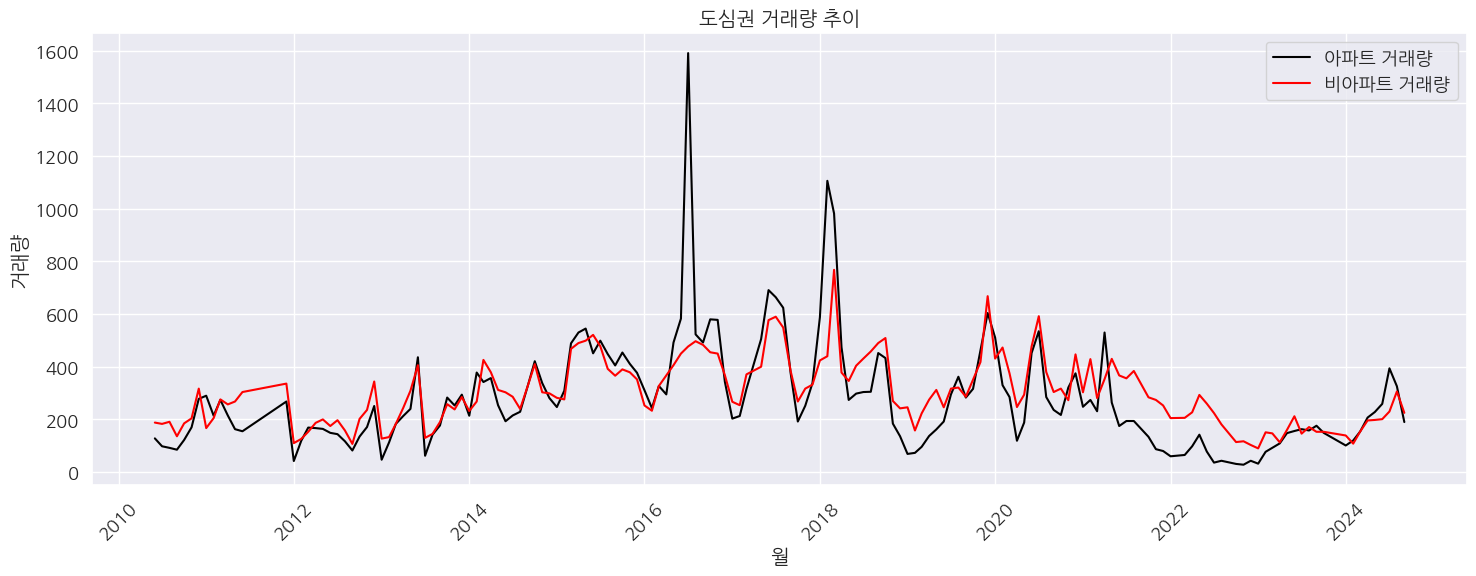

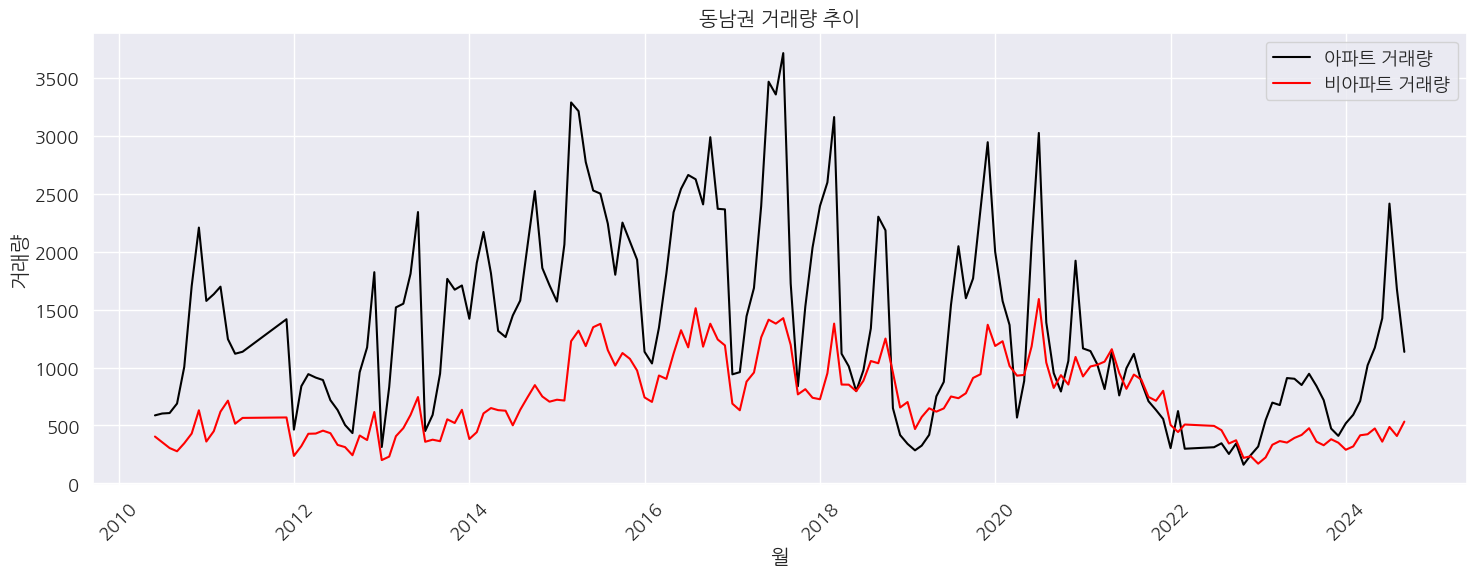

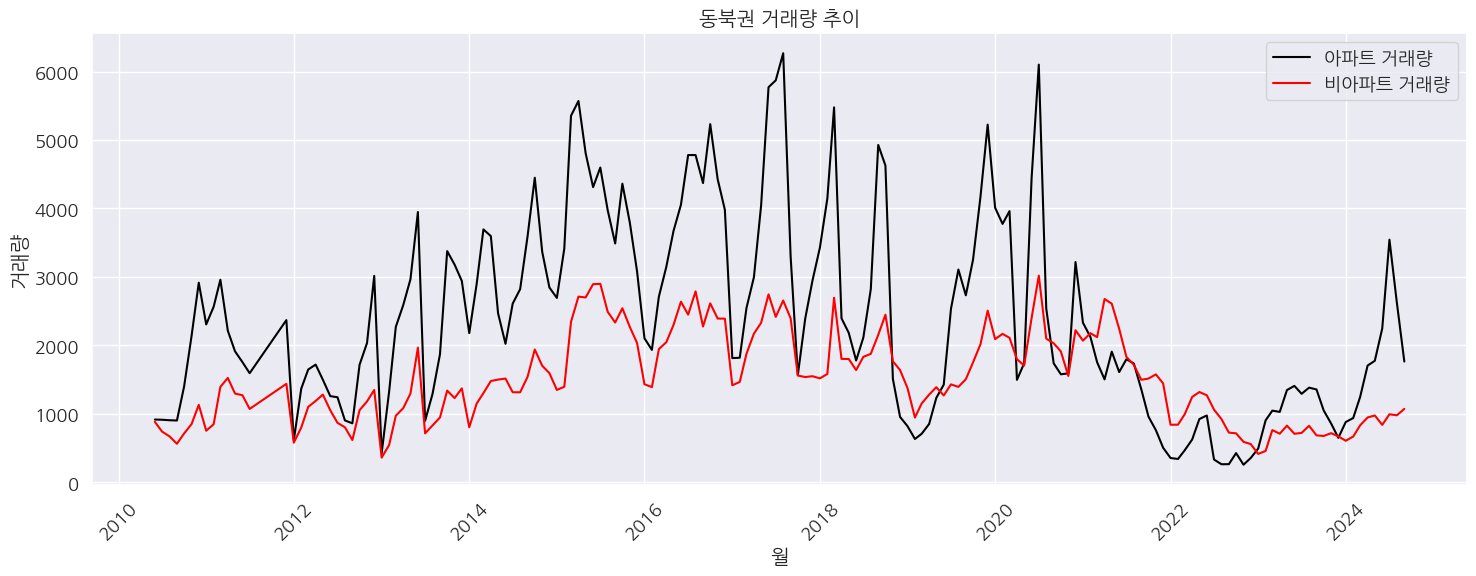

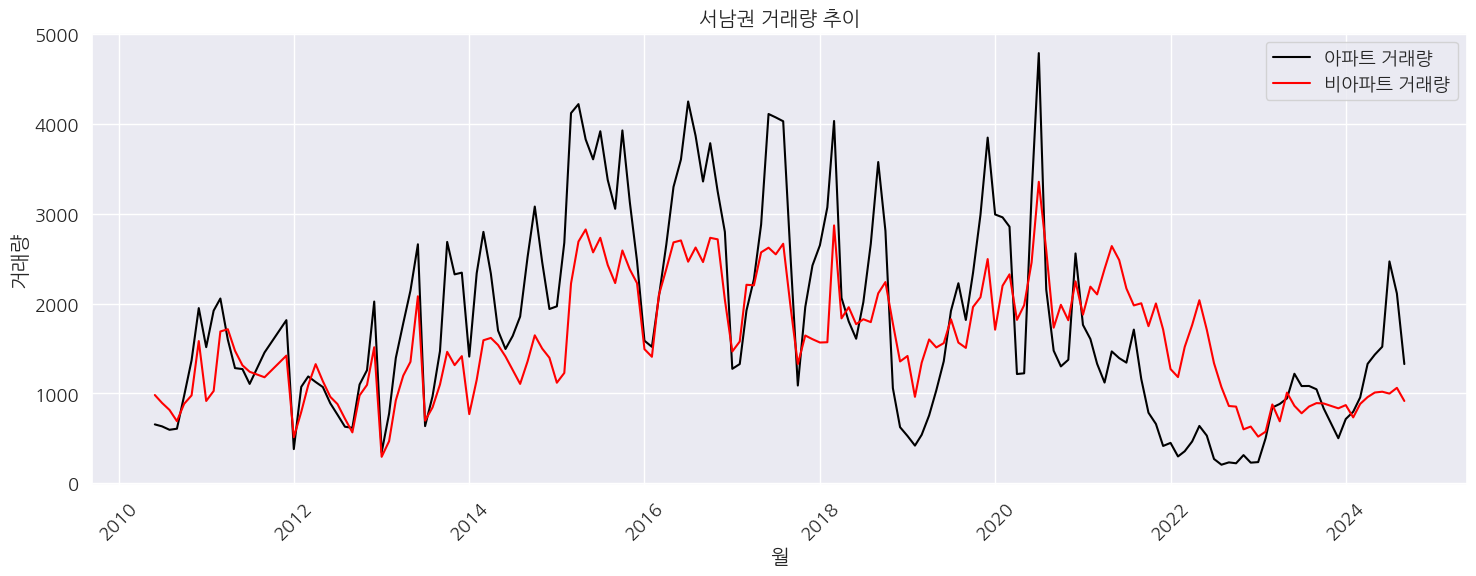

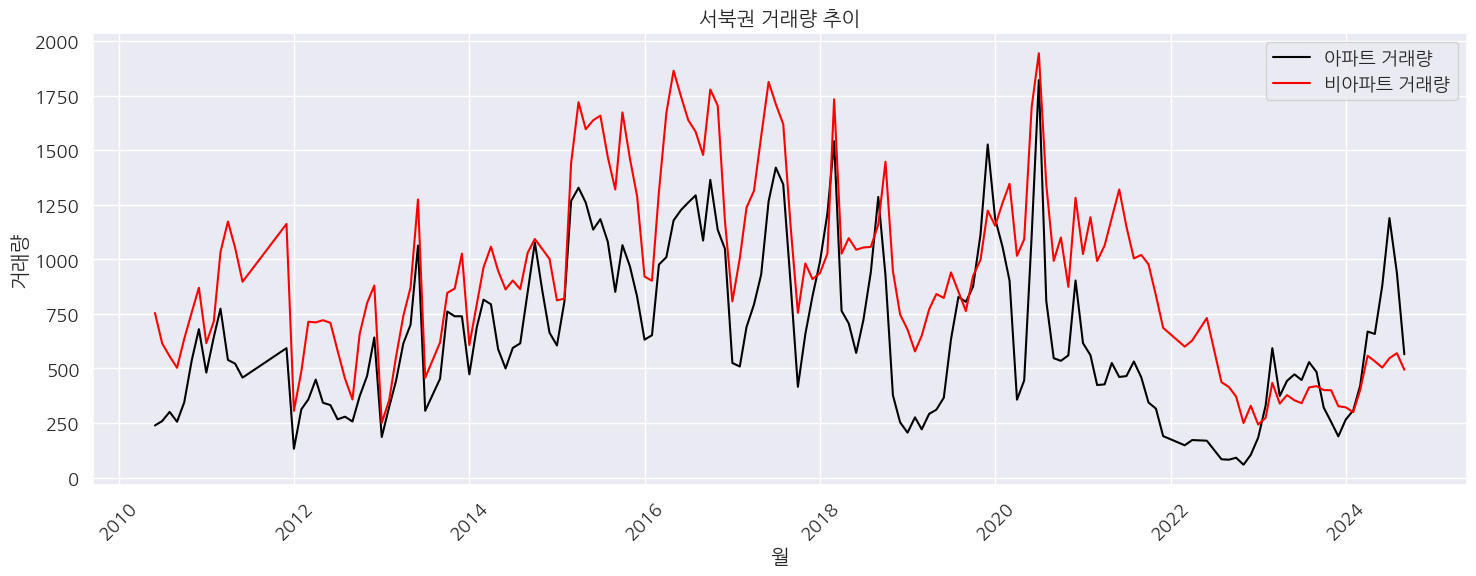

In [106]:
for district in final_estate_df['district'].unique():
    
    # 데이터 필터링
    district_data = final_estate_df[['district', 'yyyymm', 'apt_volume', 'non_apt_volume']].drop_duplicates().query(f"district == '{district}'")

    # 거래량 그래프
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=district_data, x='yyyymm', y='apt_volume', label='아파트 거래량', color='black')
    sns.lineplot(data=district_data, x='yyyymm', y='non_apt_volume', label='비아파트 거래량', color='red')
    plt.title(f"{district} 거래량 추이")
    plt.xlabel("월")
    plt.ylabel("거래량")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [98]:
# 결과를 저장할 리스트 초기화
results = []

# 권역생활권별 데이터 분석
for district in final_estate_df['district'].unique():
    
    district_data = final_estate_df.query(f"district == '{district}'")

    # 아파트 및 비아파트 거래량
    apt_volume = district_data['apt_volume'].dropna()
    non_apt_volume = district_data['non_apt_volume'].dropna()

    # 1. 단위근 검정 (ADF 검정)
    adf_apt = adfuller(apt_volume)
    adf_non_apt = adfuller(non_apt_volume)

    # 2. 상관계수
    corr_coeff = apt_volume.corr(non_apt_volume)

    # 3. 공적분 분석
    coint_stat, p_value, critical_values = coint(apt_volume, non_apt_volume)

    # 결과 저장
    results.append({
        'District': district,
        'APT_ADF_Stat': adf_apt[0],
        'APT_ADF_PValue': adf_apt[1],
        'Non_APT_ADF_Stat': adf_non_apt[0],
        'Non_APT_ADF_PValue': adf_non_apt[1],
        'Correlation_Coeff': corr_coeff,
        'Coint_Stat': coint_stat,
        'Coint_PValue': p_value
    })

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(results)

result_df

,District,APT_ADF_Stat,APT_ADF_PValue,Non_APT_ADF_Stat,Non_APT_ADF_PValue,Correlation_Coeff,Coint_Stat,Coint_PValue
0,도심권,-3.908638,0.001972,-4.676125,0.000093,0.754754,-5.417096,0.000026
1,동남권,-4.700097,0.000084,-3.416127,0.010421,0.740334,-4.855371,0.000301
2,동북권,-3.943564,0.001737,-3.455306,0.009212,0.800535,-4.133805,0.004585
3,서남권,-4.545837,0.000162,-3.880573,0.002183,0.797150,-4.651203,0.000684
4,서북권,-2.864712,0.049608,-3.725313,0.003771,0.823897,-5.513548,0.000017


## 4.2 권역생활권 별 아파트, 비아파트 & 감성분석 추이

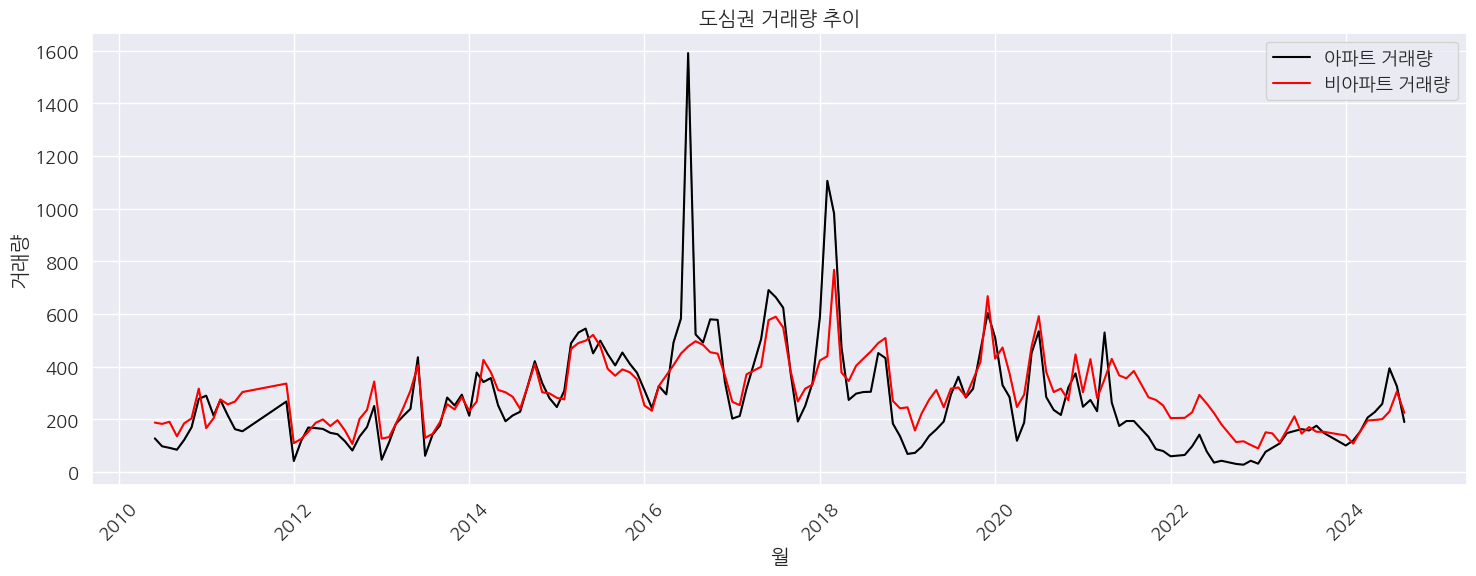

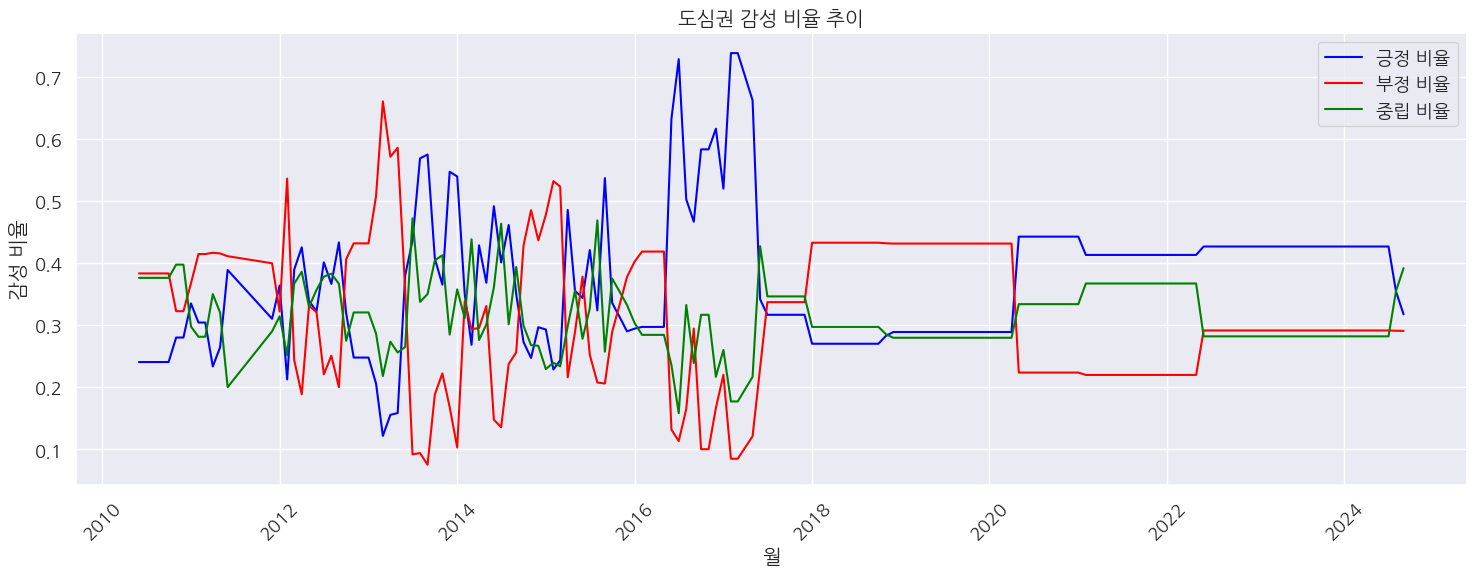

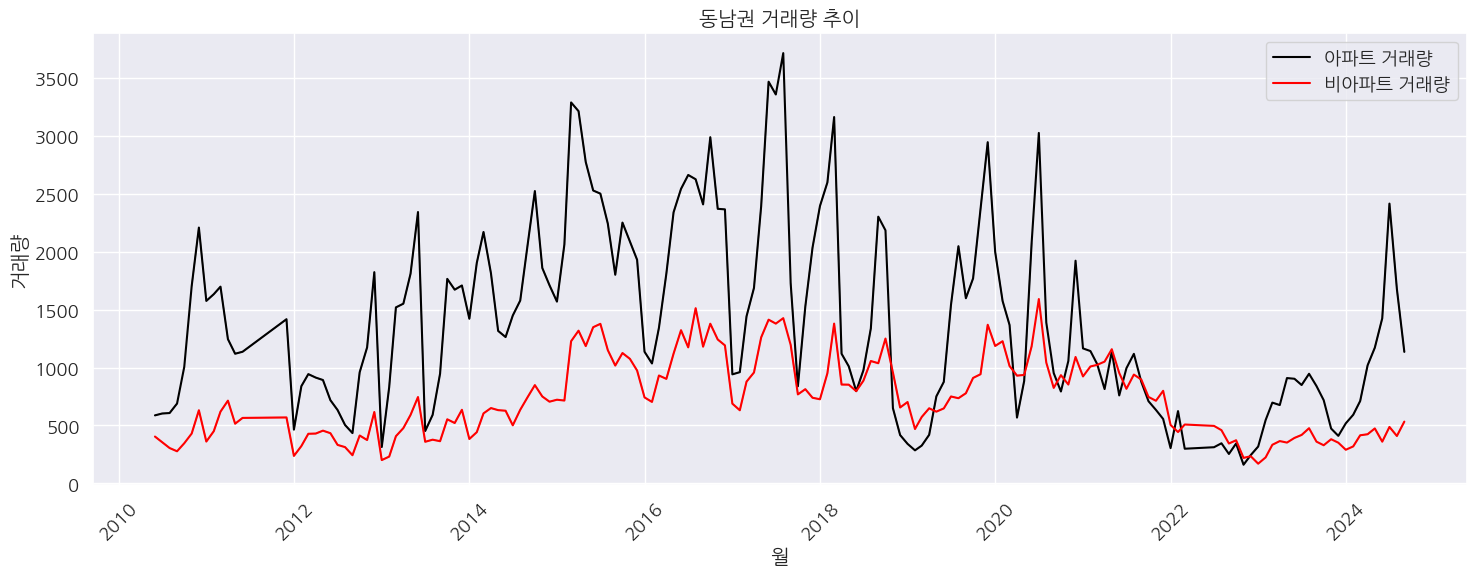

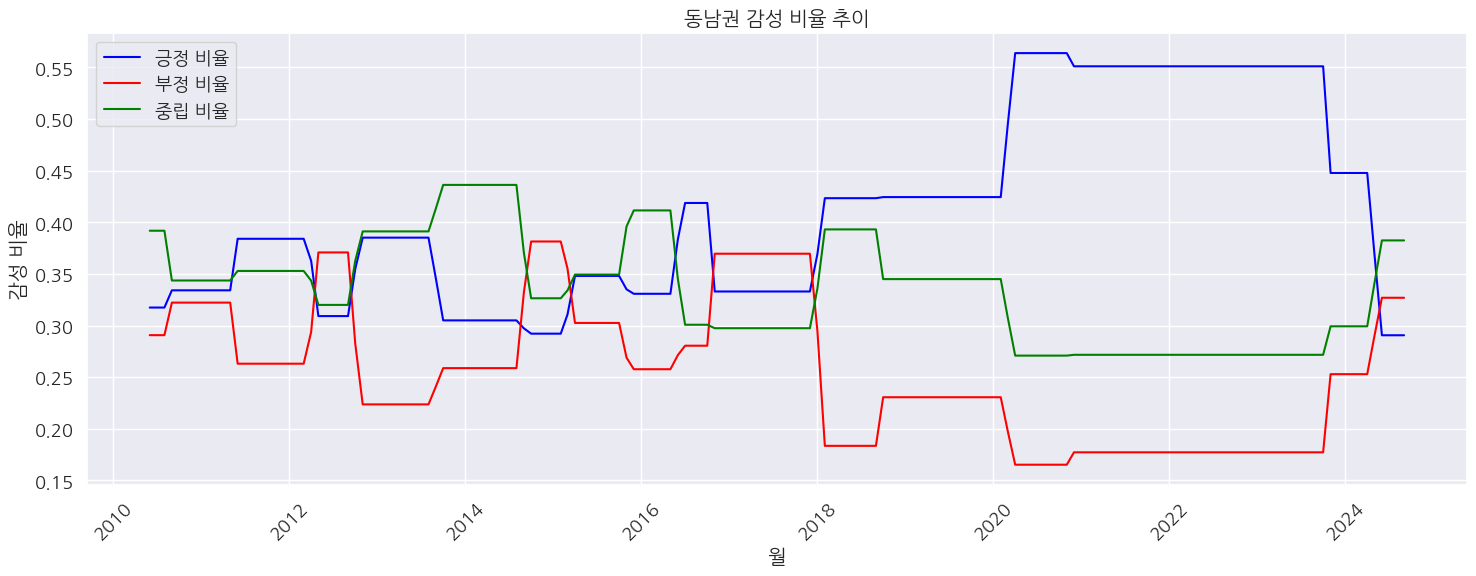

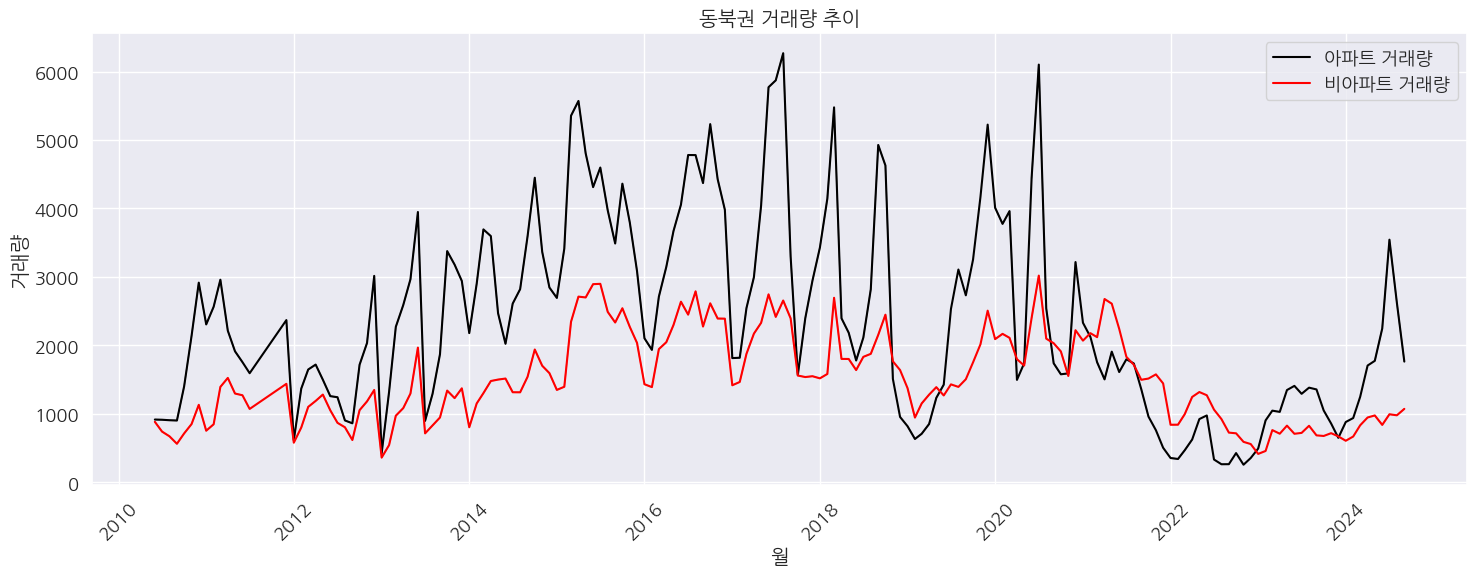

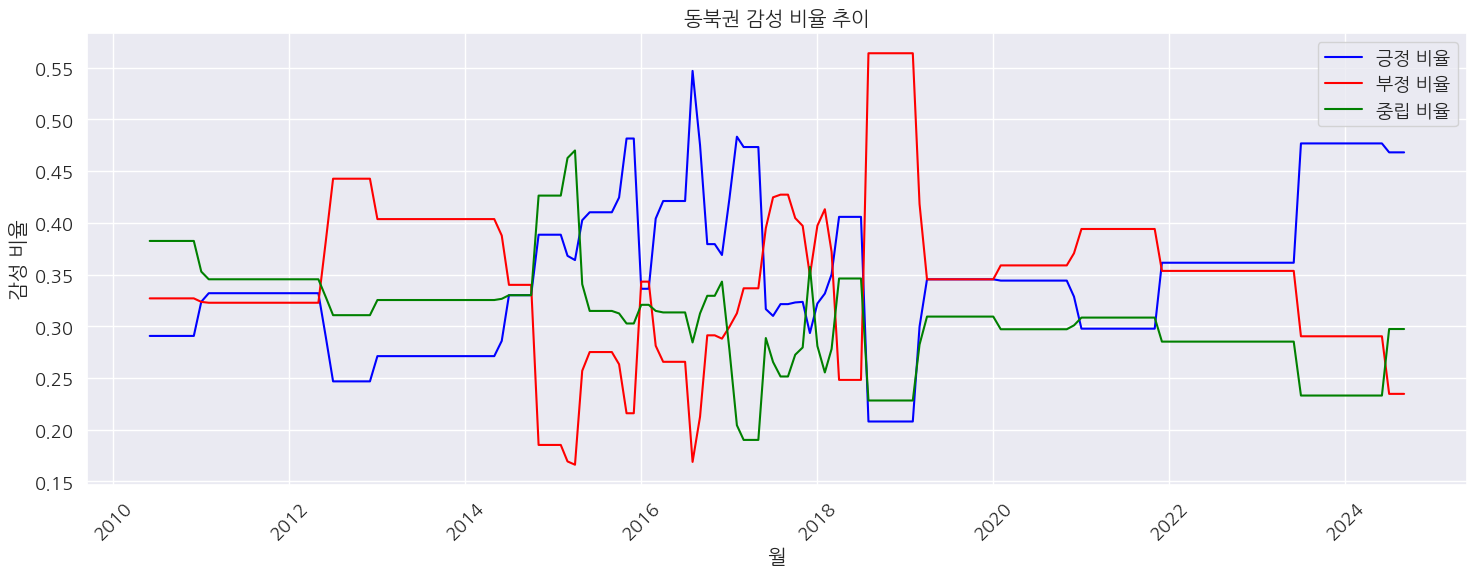

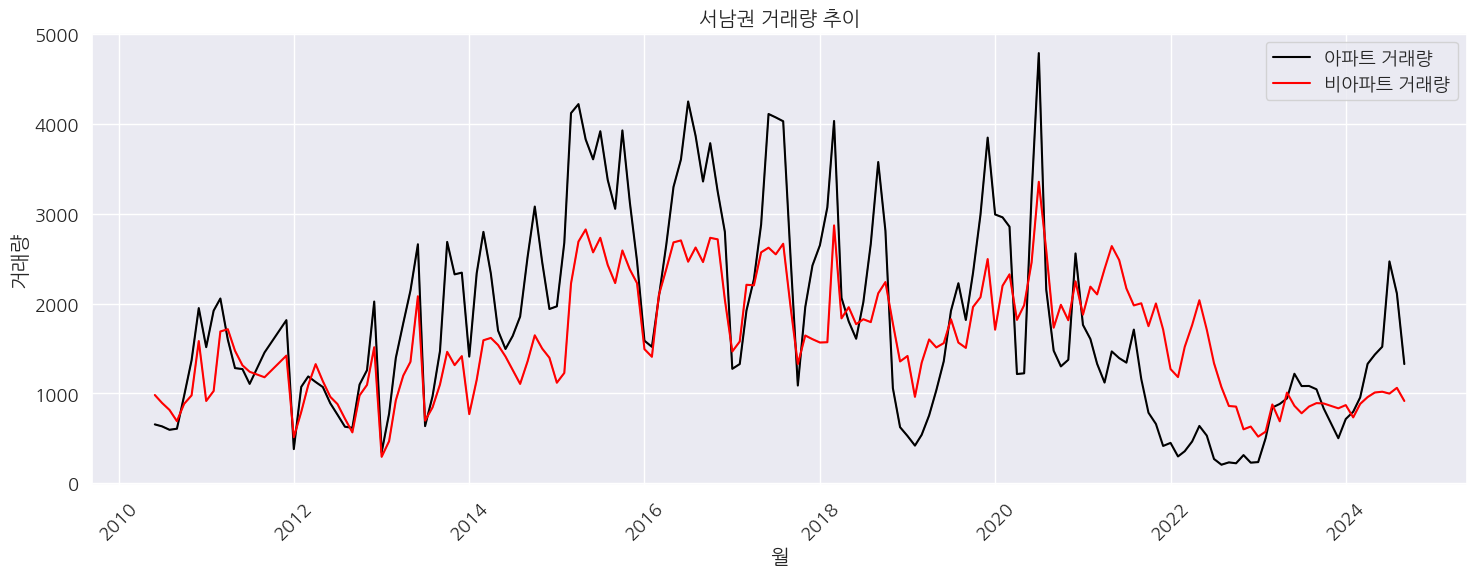

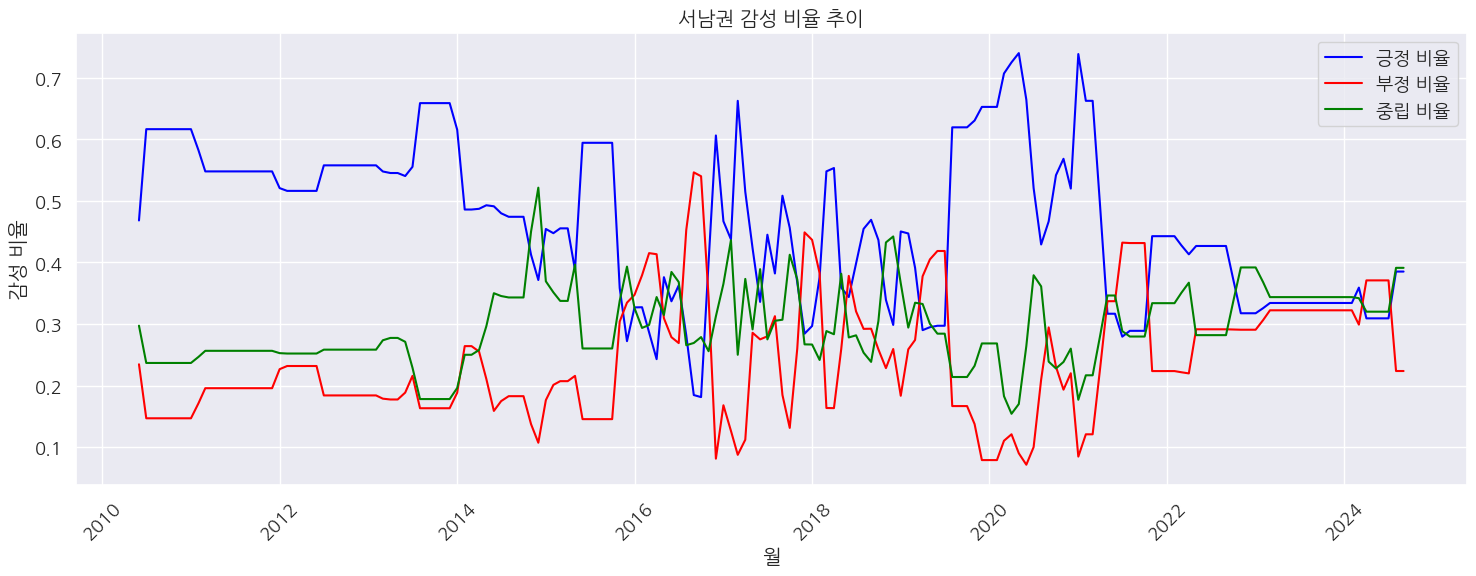

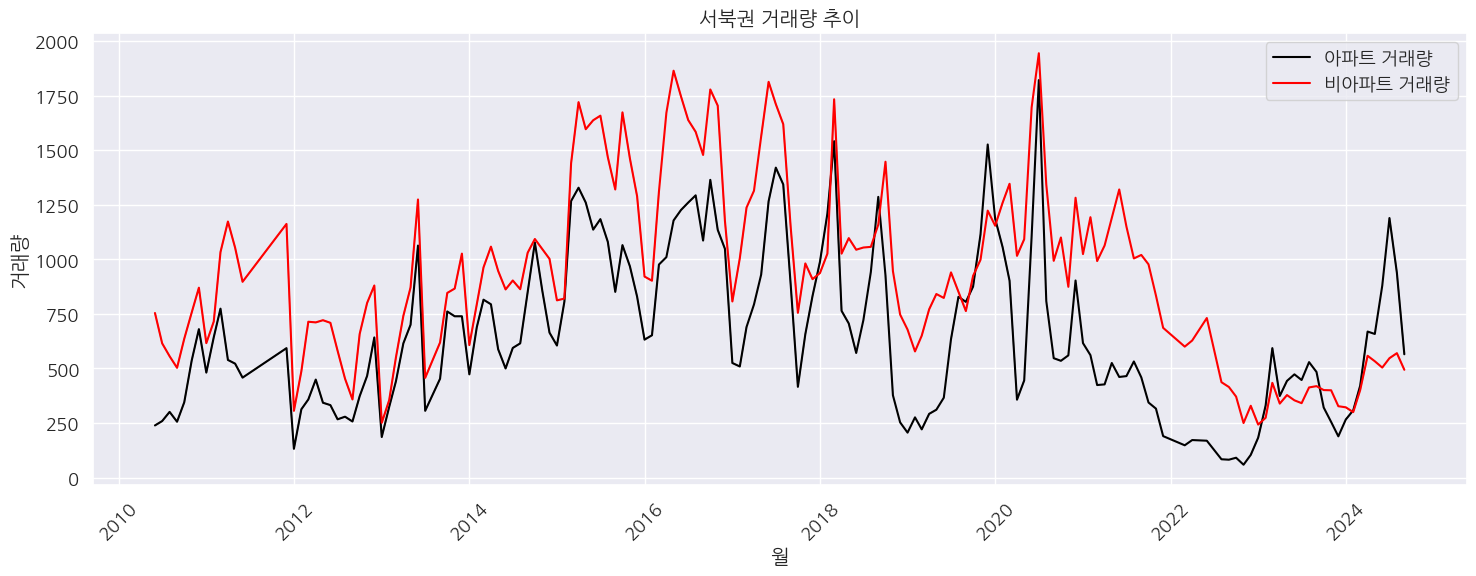

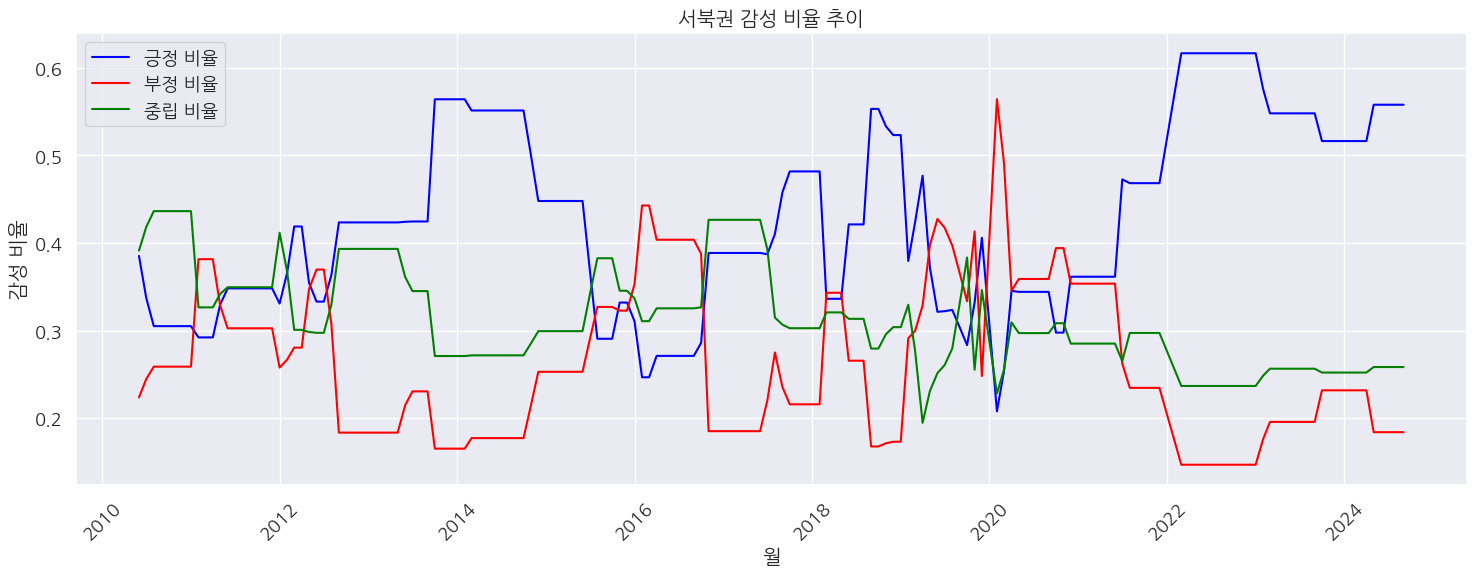

In [ ]:
for district in final_estate_df['district'].unique():
    
    # 데이터 필터링
    district_data = final_estate_df.query(f"district == '{district}'")

    # 감성 비율 그래프
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=district_data, ci=None, x='yyyymm', y='total_positive_ratio', label='긍정 비율', color='blue')
    sns.lineplot(data=district_data, ci=None, x='yyyymm', y='total_negative_ratio', label='부정 비율', color='red')
    sns.lineplot(data=district_data, ci=None, x='yyyymm', y='total_neutral_ratio', label='중립 비율', color='green')
    plt.title(f"{district} 감성 비율 추이")
    plt.xlabel("월")
    plt.ylabel("감성 비율")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [137]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 결과 저장 리스트
results = []

# 각 district별 정상성 검정
for district in final_estate_df['district'].unique():

    district_data = final_estate_df.query(f"district == '{district}'")

    # 감정 비율 컬럼 리스트
    sentiment_columns = ['total_positive_ratio', 'total_negative_ratio', 'total_neutral_ratio']

    for sentiment in sentiment_columns:

        # ADF 검정 수행
        adf_test = adfuller(district_data[sentiment].dropna())
        
        # 결과 저장
        results.append({
            'District': district,
            'Sentiment_Type': sentiment,
            'ADF_Stat': adf_test[0],  # ADF 통계량
            'P_Value': round(adf_test[1], 6),  # p-value
            'Critical_Values': adf_test[4]  # 임계값
        })

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(results).set_index(['District', 'Sentiment_Type'])

result_df

ADF_Stat   P_Value  \
District Sentiment_Type                             
도심권      total_positive_ratio -5.506212  0.000002   
         total_negative_ratio -5.499116  0.000002   
         total_neutral_ratio  -7.529466  0.000000   
동남권      total_positive_ratio -1.952347  0.307850   
         total_negative_ratio -2.616244  0.089686   
         total_neutral_ratio  -2.568907  0.099595   
동북권      total_positive_ratio -3.293874  0.015155   
         total_negative_ratio -2.214012  0.201199   
         total_neutral_ratio  -3.450761  0.009345   
서남권      total_positive_ratio -3.045325  0.030873   
         total_negative_ratio -6.018207  0.000000   
         total_neutral_ratio  -2.408527  0.139344   
서북권      total_positive_ratio -2.674573  0.078542   
         total_negative_ratio -3.000156  0.034880   
         total_neutral_ratio  -3.024412  0.032677   

                                                                 Critical_Values  
District Sentiment_Type                                                           
도심권      total_positive_ratio  {'1%': -3.4452655826028318, '5%': -2.868116205...  
         total_negative_ratio  {'1%': -3.4451978474132234, '5%': -2.868086414...  
         total_neutral_ratio   {'1%': -3.4452655826028318, '5%': -2.868116205...  
동남권      total_positive_ratio  {'1%': -3.4422089502693454, '5%': -2.866771178...  
         total_negative_ratio  {'1%': -3.4422089502693454, '5%': -2.866771178...  
         total_neutral_ratio   {'1%': -3.4422089502693454, '5%': -2.866771178...  
동북권      total_positive_ratio  {'1%': -3.441834071558759, '5%': -2.8666061267...  
         total_negative_ratio  {'1%': -3.4422304958001386, '5%': -2.866780664...  
         total_neutral_ratio   {'1%': -3.4419153151868147, '5%': -2.866641898...  
서남권      total_positive_ratio  {'1%': -3.4419770063102213, '5%': -2.866669060...  
         total_negative_ratio  {'1%': -3.4418542752662518, '5%': -2.866615022...  
         total_neutral_ratio   {'1%': -3.442081300525009, '5%': -2.8667149792...  
서북권      total_positive_ratio  {'1%': -3.4457939940402107, '5%': -2.868348590...  
         total_negative_ratio  {'1%': -3.4460159927788574, '5%': -2.868446209...  
         total_neutral_ratio   {'1%': -3.4459042013025836, '5%': -2.868397052...

In [138]:
# 결과를 저장할 리스트 초기화
sentiment_results = []

# 각 district별 분석
for district in final_estate_df['district'].unique():

    district_data = final_estate_df.query(f"district == '{district}'").sort_values(by='yyyymm')

    # 거래량과 총 감성 비율
    for volume_type in ['apt_volume', 'non_apt_volume']:

        for sentiment_type in ['total_positive_ratio', 'total_negative_ratio', 'total_neutral_ratio']:

            # 교차 상관 분석 (차분 없이 원본 데이터 사용)
            x = district_data[volume_type].values
            y = district_data[sentiment_type].values
            lags = np.arange(-len(x) + 1, len(x))  # 가능한 시간 지연
            cross_corr = correlate(x - np.mean(x), y - np.mean(y), mode='full')
            max_lag = lags[np.argmax(cross_corr)]
            max_corr = np.max(cross_corr)

            # 감성 비율 데이터 차분 처리
            y_diff = district_data[sentiment_type].diff().dropna()

            # 차분된 데이터를 다시 데이터프레임에 저장
            data = pd.DataFrame({
                volume_type: district_data[volume_type].iloc[-len(y_diff):].values,
                sentiment_type: y_diff.values
            }).dropna()

            # 인과 분석 (그랜저 인과관계)
            granger_result = grangercausalitytests(data, maxlag=3, verbose=False)

            # p-value 추출 (Volume → Sentiment, Sentiment → Volume)
            # 1. 거래량 → 감성 비율
            p_value_vol_to_sent = granger_result[1][0]['ssr_ftest'][1]  # 거래량 → 감성 비율

            # 2. 감성 비율 → 거래량
            data_reversed = data.iloc[:, ::-1]  # 컬럼 순서 반전
            granger_result_reversed = grangercausalitytests(data_reversed, maxlag=3, verbose=False)
            p_value_sent_to_vol = granger_result_reversed[1][0]['ssr_ftest'][1]

            # 결과 저장
            sentiment_results.append({
                'District': district,
                'Volume_Type': volume_type,
                'Sentiment_Type': sentiment_type,
                'Max_Lag': max_lag,
                'Max_Corr': max_corr,
                'P_Value_Vol_to_Sent': p_value_vol_to_sent,
                'P_Value_Sent_to_Vol': p_value_sent_to_vol
            })

# 결과를 데이터프레임으로 변환
sentiment_result_df = pd.DataFrame(sentiment_results).set_index(['District', 'Volume_Type', 'Sentiment_Type'])

sentiment_result_df

Max_Lag      Max_Corr  \
District Volume_Type    Sentiment_Type                                
도심권      apt_volume     total_positive_ratio        5   2388.727511   
                        total_negative_ratio      157   2523.249339   
                        total_neutral_ratio       135   2040.706734   
         non_apt_volume total_positive_ratio       82   1900.146895   
                        total_negative_ratio      250   1485.599738   
                        total_neutral_ratio       140   1083.949174   
동남권      apt_volume     total_positive_ratio     -149  15559.415729   
                        total_negative_ratio       13  10871.385464   
                        total_neutral_ratio        62   7462.648496   
         non_apt_volume total_positive_ratio     -149   8261.232975   
                        total_negative_ratio       34   3723.087790   
                        total_neutral_ratio       168   3098.546100   
동북권      apt_volume     total_positive_ratio       11  19484.534221   
                        total_negative_ratio     -166  20647.703059   
                        total_neutral_ratio       159  13258.916660   
         non_apt_volume total_positive_ratio      -72   9898.455344   
                        total_negative_ratio     -156   9311.972372   
                        total_neutral_ratio       240   6764.849986   
서남권      apt_volume     total_positive_ratio      214  24995.547820   
                        total_negative_ratio      -49  19619.134835   
                        total_neutral_ratio        42  17674.923907   
         non_apt_volume total_positive_ratio      244  13865.383525   
                        total_negative_ratio      -39  13320.173196   
                        total_neutral_ratio        43  10552.633826   
서북권      apt_volume     total_positive_ratio       46   4894.582213   
                        total_negative_ratio      -74   3812.441803   
                        total_neutral_ratio       235   2980.147003   
         non_apt_volume total_positive_ratio       67   7466.423757   
                        total_negative_ratio        2   5400.888826   
                        total_neutral_ratio       244   3558.773798   

                                              P_Value_Vol_to_Sent  \
District Volume_Type    Sentiment_Type                              
도심권      apt_volume     total_positive_ratio             0.939901   
                        total_negative_ratio             0.917960   
                        total_neutral_ratio              0.836229   
         non_apt_volume total_positive_ratio             0.761619   
                        total_negative_ratio             0.982317   
                        total_neutral_ratio              0.687083   
동남권      apt_volume     total_positive_ratio             0.892966   
                        total_negative_ratio             0.894330   
                        total_neutral_ratio              0.726931   
         non_apt_volume total_positive_ratio             0.445336   
                        total_negative_ratio             0.768108   
                        total_neutral_ratio              0.726258   
동북권      apt_volume     total_positive_ratio             0.201961   
                        total_negative_ratio             0.117390   
                        total_neutral_ratio              0.671492   
         non_apt_volume total_positive_ratio             0.331906   
                        total_negative_ratio             0.087508   
                        total_neutral_ratio              0.335802   
서남권      apt_volume     total_positive_ratio             0.075489   
                        total_negative_ratio             0.463826   
                        total_neutral_ratio              0.001429   
         non_apt_volume total_positive_ratio             0.613815   
                        total_negative_ratio             0.990415   
                        total_neutral_ratio     

## 4.3 권역생활권 거래량 및 권역생활권/토픽 별 감성추이 분석

In [155]:
final_estate_df['topic_category'].unique()

array(['상권 개발 및 정비 사업', '시설 설치 및 안전 공사', '어린이 및 공원/문화 조성',
       '주민 및 교육 지원 사업', '부동산 가격 및 분양 거래', '서비스 및 센터 운영', '부동산 정책 관련'],
      dtype=object)

In [157]:
final_estate_df.loc[final_estate_df['topic_category'] == '부동산 가격 및 분양 거래', 'topic_category'] = '부동산 정책 및 거래'
final_estate_df.loc[final_estate_df['topic_category'] == '부동산 정책 관련', 'topic_category'] = '부동산 정책 및 거래'

In [171]:
estate_volume_df2.loc[estate_volume_df2['topic_category'] == '부동산 가격 및 분양 거래', 'topic_category'] = '부동산 정책 및 거래'
estate_volume_df2.loc[estate_volume_df2['topic_category'] == '부동산 정책 관련', 'topic_category'] = '부동산 정책 및 거래'

bbbb = estate_volume_df2.groupby('topic_category')[['positive_ratio', 'neutral_ratio', 'negative_ratio']].mean()
bbbb['sum'] = bbbb['positive_ratio'] + bbbb['neutral_ratio'] + bbbb['negative_ratio']
bbbb

,positive_ratio,neutral_ratio,negative_ratio,sum
topic_category,,,,
부동산 정책 및 거래,0.281650,0.321044,0.397306,1.0
상권 개발 및 정비 사업,0.451982,0.327354,0.220664,1.0
서비스 및 센터 운영,0.450798,0.385196,0.164006,1.0
시설 설치 및 안전 공사,0.472589,0.322159,0.205252,1.0
어린이 및 공원/문화 조성,0.713766,0.201858,0.084377,1.0
주민 및 교육 지원 사업,0.605913,0.260697,0.133390,1.0


In [182]:
cccc = estate_volume_df2.groupby(['topic_category', 'district'])[['title']].nunique().reset_index()
cccc = cccc.pivot_table(columns='district', index='topic_category', values='title').sort_index(axis=1)
cccc

district,도심권,동남권,동북권,서남권,서북권
topic_category,,,,,
부동산 정책 및 거래,48.0,354.0,90.0,72.0,48.0
상권 개발 및 정비 사업,1823.0,3066.0,2252.0,2464.0,1088.0
서비스 및 센터 운영,86.0,166.0,169.0,208.0,61.0
시설 설치 및 안전 공사,218.0,375.0,466.0,558.0,155.0
어린이 및 공원/문화 조성,136.0,191.0,364.0,382.0,124.0
주민 및 교육 지원 사업,278.0,323.0,613.0,658.0,239.0


In [195]:
# 결과를 저장할 리스트 초기화
sentiment_topic_results = []

# 각 district별 분석
for district in final_estate_df['district'].unique():

    district_data = final_estate_df.query(f"district == '{district}'").sort_values(by='yyyymm')

    # 각 topic_category 별 분석
    for topic in district_data['topic_category'].unique():
        topic_data = district_data.query(f"topic_category == '{topic}'").sort_values(by='yyyymm')

        for sentiment_type in ['positive_ratio', 'negative_ratio', 'neutral_ratio']:
            for volume_type in ['apt_volume', 'non_apt_volume']:

                try:

                    # 교차 상관 분석 (원본 데이터 사용)
                    x = topic_data[volume_type].values
                    y = topic_data[sentiment_type].values
                    lags = np.arange(-len(x) + 1, len(x))
                    cross_corr = correlate(x - np.mean(x), y - np.mean(y), mode='full')
                    max_lag = lags[np.argmax(cross_corr)]
                    max_corr = np.max(cross_corr)

                    # 감성 비율 차분 처리
                    y_diff = topic_data[sentiment_type].diff().dropna()

                    # 차분된 데이터를 다시 데이터프레임에 저장
                    data = pd.DataFrame({
                        volume_type: topic_data[volume_type].iloc[-len(y_diff):].values,
                        sentiment_type: y_diff.values
                    }).dropna()

                    # Granger 인과관계 검정
                    granger_result = grangercausalitytests(data, maxlag=3, verbose=False)

                    # p-value 추출 (Volume → Sentiment, Sentiment → Volume)
                    p_value_vol_to_sent = granger_result[1][0]['ssr_ftest'][1]  # 거래량 → 감성 비율
                    data_reversed = data.iloc[:, ::-1]  # 컬럼 순서 반전
                    granger_result_reversed = grangercausalitytests(data_reversed, maxlag=3, verbose=False)
                    p_value_sent_to_vol = granger_result_reversed[1][0]['ssr_ftest'][1]  # 감성 비율 → 거래량

                    # 결과 저장
                    sentiment_topic_results.append({
                        'District': district,
                        'Topic_Category': topic,
                        'Volume_Type': volume_type,
                        'Sentiment_Type': sentiment_type,
                        'Max_Lag': max_lag,
                        'Max_Corr': max_corr,
                        'P_Value_Vol_to_Sent': p_value_vol_to_sent,
                        'P_Value_Sent_to_Vol': p_value_sent_to_vol
                    })

                except:
                    sentiment_topic_results.append({
                        'District': district,
                        'Topic_Category': topic,
                        'Volume_Type': volume_type,
                        'Sentiment_Type': sentiment_type,
                        'Max_Lag': max_lag,
                        'Max_Corr': max_corr,
                        'P_Value_Vol_to_Sent': np.nan,
                        'P_Value_Sent_to_Vol': np.nan
                    })

# 결과를 데이터프레임으로 변환
sentiment_topic_result_df = pd.DataFrame(sentiment_topic_results).sort_values(['District', 'Volume_Type'])#.set_index(['District', 'Volume_Type', 'Sentiment_Type'])

sentiment_topic_result_df


,District,Topic_Category,Volume_Type,Sentiment_Type,Max_Lag,Max_Corr,P_Value_Vol_to_Sent,P_Value_Sent_to_Vol
0,도심권,상권 개발 및 정비 사업,apt_volume,positive_ratio,-6,1874.746003,0.743279,0.708517
2,도심권,상권 개발 및 정비 사업,apt_volume,negative_ratio,56,1158.411471,0.066006,0.715316
4,도심권,상권 개발 및 정비 사업,apt_volume,neutral_ratio,-64,1215.624740,0.190801,0.925006
6,도심권,시설 설치 및 안전 공사,apt_volume,positive_ratio,-9,780.939736,0.888083,0.264052
8,도심권,시설 설치 및 안전 공사,apt_volume,negative_ratio,27,448.538854,0.839586,0.610878
...,...,...,...,...,...,...,...,...
171,서북권,서비스 및 센터 운영,non_apt_volume,negative_ratio,-16,764.334435,0.224339,0.353374
173,서북권,서비스 및 센터 운영,non_apt_volume,neutral_ratio,-1,846.403332,0.639184,0.203529
175,서북권,부동산 정책 및 거래,non_apt_volume,positive_ratio,-16,951.131481,0.852194,0.746758
177,서북권,부동산 정책 및 거래,non_apt_volume,negative_ratio,-11,925.623640,0.388061,0.755077


In [ ]:
# sentiment_topic_result_df.columns = ['권역생활권', '토픽', '거래량', '감성 비율', 'Max Lag', 'Max Corr', 'P_Value Vol_to_Sent', 'P_Value Sent_to_Vol']

# for topic in sentiment_topic_result_df['토픽'].unique():

#     sample_sentiment_topic_result_df = sentiment_topic_result_df.query(f"토픽 == '{topic}'")

#     sample_sentiment_topic_result_df.loc[sentiment_topic_result_df['거래량'] == 'apt_volume', '거래량'] = '아파트'
#     sample_sentiment_topic_result_df.loc[sentiment_topic_result_df['거래량'] == 'non_apt_volume', '거래량'] = '비아파트'
#     sample_sentiment_topic_result_df.loc[sentiment_topic_result_df['감성 비율'] == 'positive_ratio', '감성 비율'] = 'positive ratio'
#     sample_sentiment_topic_result_df.loc[sentiment_topic_result_df['감성 비율'] == 'negative_ratio', '감성 비율'] = 'negative ratio'
#     sample_sentiment_topic_result_df.loc[sentiment_topic_result_df['감성 비율'] == 'neutral_ratio', '감성 비율'] = 'neutral ratio'

#     sample_sentiment_topic_result_df.set_index(['권역생활권', '거래량', '감성 비율']).to_excel(f"{topic.replace('/', ' ')}_감성비율거래량_검정결과.xlsx")